#Persian News Classification

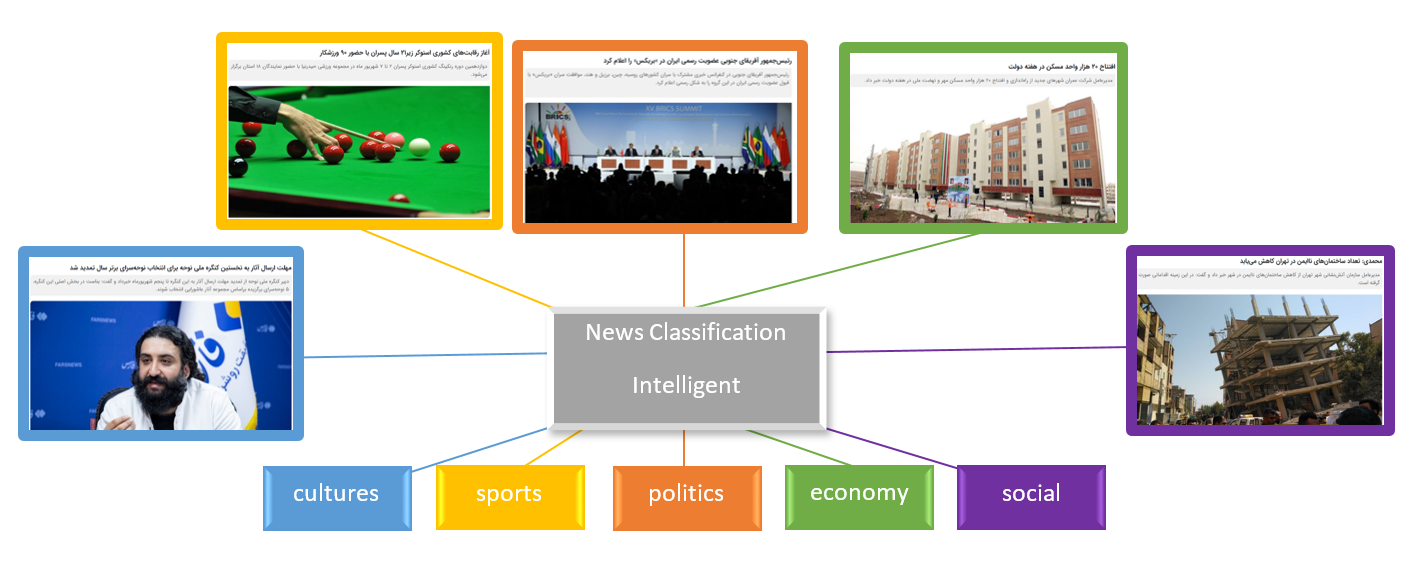




##Import packages

In [1]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [4]:
!pip install -qU transformers
!pip install -qU sentence-transformers
!pip install -qU accelerate -U
!pip install -qU datasets transformers huggingface-hub kaggle
!pip install -qU seaborn
!pip install -qU pandas matplotlib

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import pandas as pd
import numpy as np

import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from datasets import load_metric


from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_metric
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##DATASET

In [ ]:
DATASET_PATH = '/content/gdrive/MyDrive/Dataset'

In [ ]:
#farsnews
data_read = pd.read_csv(DATASET_PATH +'/farsnews.csv')
data_f = data_read.copy()

data_f['title'] = data_f['title'].apply(lambda t: t if isinstance(t, str) else None)
data_f = data_f.dropna()
data_f['title'] = data_f['title'].apply(lambda t: t if len(t) > 16 else None)
data_f = data_f.dropna()
data_f = data_f.drop_duplicates()
data_f['title'] = data_f['title'].apply(lambda t: t.replace('|', ' '))


data_f = data_f[data_f['label'] != 'arts-media']

data_f['label']
data_f = data_f[['title', 'label']]
data_f = data_f.astype('str')
data_f = data_f.reset_index(drop=True)

print(data_f.shape)
data_f.head()

<ipython-input-9-01a60db42186>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f['title'] = data_f['title'].apply(lambda t: t if len(t) > 16 else None)


(29976, 2)


,title,label
0,جنجالی های هفته دستگیری یک پرسپولیسی و انتظا...,sports
1,خشم برزیلی ها در انتظار وارث سلطان,sports
2,هفته ۲۴ لیگ برتر اولین برد گل گهر در دوران پس...,sports
3,آخرین وضعیت کمپ حجازی به روایت عکس,sports
4,والیبال قهرمانی جهان تمرین 2 ساعته ملی پوشان ...,sports


In [ ]:
label_counts = data_f['label'].value_counts()
print(label_counts)

culture     6000
sports      5999
politics    5994
economy     5992
social      5991
Name: label, dtype: int64


In [ ]:
#tasnim
data_read = pd.read_csv(DATASET_PATH +'/tasnim.csv')
data_t = data_read.copy()
data_t = data_t.drop(['Unnamed: 0','date', 'text','word2vec_title'], axis=1)
data_t['title'] = data_t['title'].apply(lambda t: t if isinstance(t, str) else None)
data_t = data_t.dropna()
data_t['title'] = data_t['title'].apply(lambda t: t if len(t) > 16 else None)
data_t = data_t.dropna()
data_t = data_t.drop_duplicates()
data_t['title'] = data_t['title'].apply(lambda t: t.replace('|', ' '))

label_dict = {'culture-media': 'culture'}

data_t['label'] = data_t['label'].replace(label_dict)


data_t = data_t[['title', 'label']]
data_t = data_t.astype('str')
data_t = data_t.reset_index(drop=True)

print(data_t.shape)
data_t.head()

(27836, 2)


<ipython-input-11-a448435df8f2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_t['title'] = data_t['title'].apply(lambda t: t.replace('|', ' '))
<ipython-input-11-a448435df8f2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_t['label'] = data_t['label'].replace(label_dict)


,title,label
0,فیلم آغاز روند کاهشی قیمت کالاهای اساسی از او...,culture
1,فیلم افشاگری های جنجالی سینماگران زن/ لزوم ور...,culture
2,فیلم حساس ترین مواضع اسرائیل در بانک اهداف جب...,culture
3,فیلم مقصر اصلی ماجرای هیرمند کیست؟,culture
4,فیلم آشنایی با سران اسرائیل/ قسمت ششم: «گلدا ...,culture


In [ ]:
label_counts = data_t['label'].value_counts()
print(label_counts)

economy     6095
culture     5750
politics    5483
sports      5347
social      5161
Name: label, dtype: int64


In [ ]:
data = pd.concat([data_f, data_t])
print(data.shape)
data.head()

(57812, 2)


,title,label
0,جنجالی های هفته دستگیری یک پرسپولیسی و انتظا...,sports
1,خشم برزیلی ها در انتظار وارث سلطان,sports
2,هفته ۲۴ لیگ برتر اولین برد گل گهر در دوران پس...,sports
3,آخرین وضعیت کمپ حجازی به روایت عکس,sports
4,والیبال قهرمانی جهان تمرین 2 ساعته ملی پوشان ...,sports


In [ ]:
label_counts = data['label'].value_counts()
print(label_counts)

economy     12087
culture     11750
politics    11477
sports      11346
social      11152
Name: label, dtype: int64


In [ ]:
le = LabelEncoder()

data['label'] = le.fit_transform(data['label'])
data.head()

,title,label
0,جنجالی های هفته دستگیری یک پرسپولیسی و انتظا...,4
1,خشم برزیلی ها در انتظار وارث سلطان,4
2,هفته ۲۴ لیگ برتر اولین برد گل گهر در دوران پس...,4
3,آخرین وضعیت کمپ حجازی به روایت عکس,4
4,والیبال قهرمانی جهان تمرین 2 ساعته ملی پوشان ...,4


In [ ]:
label_counts = data['label'].value_counts()
print(label_counts)

1    12087
0    11750
2    11477
4    11346
3    11152
Name: label, dtype: int64



##Preprocessing

*   Tokenization
*   Removing stop words
*   Stemming
*   List item




    
    



In [ ]:
# This variable specifies the maximum number of characters in each sentence. Longer sentences will be truncated.
MAX_LEN = 512

# If you have better GPUs, you can increase these values:)
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16


tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-zwnj-base')
#tokenizer = BertTokenizer.from_pretrained("setu4993/LaBSE")

metric = load_metric('matthews_correlation')

In [ ]:
# Encode categories and convert them to integer numbers
data["paragraphs"] = data["title"]
encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

data['encoded_cat'] = data['label'].apply(lambda x: encode_cat(x))

In [ ]:
class FarsNews(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __getitem__(self, index):
        paragraph = str(self.data.paragraphs[index])
        paragraph = " ".join(paragraph.split())
        inputs = self.tokenizer.encode_plus(
            paragraph,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        item = {key: torch.tensor(inputs[key]) for key in inputs}
        item['labels'] = torch.tensor(self.data.encoded_cat[index], dtype=torch.long)

        return item

    def __len__(self):
        return self.len

In [ ]:

# Split the dataset into training, testing, and validation sets and convert them to Pytorch datasets

train_size = 0.8
eval_size = 0.35

train_dataset=data.sample(frac=train_size,random_state=46)
test_dataset=data.drop(train_dataset.index).reset_index(drop=True)

eval_dataset=test_dataset.sample(frac=eval_size,random_state=46)
test_dataset=test_dataset.drop(eval_dataset.index).reset_index(drop=True)

train_dataset = train_dataset.reset_index(drop=True)
eval_dataset = eval_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("EVAL Dataset: {}".format(eval_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = FarsNews(train_dataset, tokenizer, MAX_LEN)
eval_set = FarsNews(eval_dataset, tokenizer, MAX_LEN)
testing_set = FarsNews(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (27836, 4)
TRAIN Dataset: (22269, 4)
EVAL Dataset: (1948, 4)
TEST Dataset: (3619, 4)


##Model

In [ ]:
# Load ParsBERT pre-trained model with the different head that is appropriate for sequence classification

model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-zwnj-base", num_labels=5)
#model = AutoModelForSequenceClassification.from_pretrained("setu4993/LaBSE", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    #persian fars text classification finetuned
    f"pft-clf-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    num_train_epochs,
    weight_decay,
    load_best_model_at_end=True,
    metric_for_best_model='matthews_correlation',
    push_to_hub=True,
)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=training_set,
    eval_dataset=eval_set,
    compute_metrics=compute_metrics
)
trainer.train()

##Prediction

In [ ]:
evaluation_result = trainer.evaluate()
predictions = trainer.predict( testing_set)
predicted_labels = predictions.predictions.argmax(axis=1)
print(predicted_labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[4 2 1 ... 0 0 0]


In [ ]:
True_labels = []
for i in range(len(predicted_labels)):
  True_labels.append(testing_set[i]['labels'].item() )

In [ ]:
#farsnews parsbert
from sklearn.metrics import confusion_matrix
y_true = True_labels
y_pred = predicted_labels
confusion_matrix(y_true, y_pred)

In [ ]:
#farsnews parsbert
from sklearn.metrics import classification_report
print(classification_report(True_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       751
           1       0.83      0.85      0.84       766
           2       0.89      0.89      0.89       790
           3       0.83      0.83      0.83       804
           4       0.88      0.86      0.87       786

    accuracy                           0.88      3897
   macro avg       0.88      0.88      0.88      3897
weighted avg       0.88      0.88      0.88      3897

